In [1]:
# Read the dataset
import scipy.io as spio
import numpy as np

BahramFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/BahramFace.mat')
DJFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/DJFace.mat')
NickFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/NickFace.mat')
RoohiFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/RoohiFace.mat')
SarahFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/SarahFace.mat')

AllData = np.concatenate((BahramFace['Intensification_Data'],
                            DJFace['Intensification_Data'],
                            NickFace['Intensification_Data'],
                            RoohiFace['Intensification_Data'],
                            SarahFace['Intensification_Data']), axis=0)

AllLabels = np.concatenate((BahramFace['Intensification_Label'],
                            DJFace['Intensification_Label'],
                            NickFace['Intensification_Label'],
                            RoohiFace['Intensification_Label'],
                            SarahFace['Intensification_Label']), axis=0)

print(AllData.shape, AllData.dtype, AllLabels.shape, AllLabels.dtype)
print(np.mean(AllLabels==0), np.mean(AllLabels==1), np.mean(AllLabels==2), np.mean(AllLabels==3))
print((AllLabels +  1).max(axis=0))

(18720, 205, 16) float64 (18720, 1) uint8
0.833333333333 0.166666666667 0.0 0.0
[2]


In [2]:
# Train and test split
from sklearn.model_selection import train_test_split

X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(AllData, AllLabels, test_size=0.30)

print(X_train_valid.shape, X_test.shape, Y_train_valid.shape, Y_test.shape)

(13104, 205, 16) (5616, 205, 16) (13104, 1) (5616, 1)


In [3]:
from utilities import *

# Normalizing/standardizing the input data features
X_train_valid_norm, X_test_norm = standardize(test=X_test, train=X_train_valid)

# Onehot encoding/vectorizing the output data labels
print(np.mean((Y_train_valid+1).reshape(-1)==0), np.mean((Y_train_valid+1).reshape(-1)==1),
     np.mean((Y_train_valid+1).reshape(-1)==2), np.mean((Y_train_valid+1).reshape(-1)==3))

print(np.mean((Y_test+1).reshape(-1)==0), np.mean((Y_test+1).reshape(-1)==1),
     np.mean((Y_test+1).reshape(-1)==2), np.mean((Y_test+1).reshape(-1)==3))

# Y_train_valid_onehot = one_hot(labels=(Y_train_valid+1).reshape(-1), n_class=2) 
# print(Y_train_valid_onehot.shape, Y_train_valid_onehot.dtype, 
Y_test_onehot = one_hot(labels=(Y_test+1).reshape(-1), n_class=2) 
print(Y_test_onehot.shape, Y_test_onehot.dtype)

0.0 0.831043956044 0.168956043956 0.0
0.0 0.838675213675 0.161324786325 0.0
(5616, 2) float64


In [4]:
# X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(AllData, AllLabels, test_size=0.30)
X_train_norm, X_valid_norm, Y_train, Y_valid = train_test_split(X_train_valid_norm, Y_train_valid, 
                                                                              test_size=0.30)

In [5]:
def get_batches2(X_norm, Y_labels):
    # X normalized and Y NOT onehot encoded/vectorized
    X, Y = X_norm, Y_labels
    AllLabels = Y_labels # 100%

    # non = 0 is 87%  AllLabelZero
    # tgt = 1 is 13%  AllLabelOne
    AllLabelZero = (AllLabels==0).reshape(-1) # 87%
    AllLabelOne = (AllLabels==1).reshape(-1) # 13%

    X_non, Y_non = X[AllLabelZero], Y[AllLabelZero] # 87%
    X_tgt, Y_tgt = X[AllLabelOne], Y[AllLabelOne] # 13%
    #     print('X_non.shape, Y_non.shape', X_non.shape, Y_non.shape)
    #     print('X_tgt.shape, Y_tgt.shape', X_tgt.shape, Y_tgt.shape)

    # Non-target batch size for get_batches from non-target data
    batch_size = X_tgt.shape[0] # 13% -> tgt = 1 is 13%  AllLabelOne
    assert X_tgt.shape[0] == Y_tgt.shape[0]
#     print('batch_size', batch_size)
    
    # Convolvolutional minibatching technique
    stride = batch_size
    pad = 0
    kernel_size = batch_size
    inputs, filters, kernel_size, strides, padding = X_non, 1, batch_size, batch_size//2, 0
#     print('inputs.shape, filters, kernel_size, strides, padding', 
#           inputs.shape, filters, kernel_size, strides, padding)
    n_batches = (inputs.shape[0] - kernel_size + (2*padding))//strides  + 1 
#     print('n_batches', n_batches)
    
    # Loop over target batches: start, stop, step
    for i in range(0, n_batches, 1):
        each_X_norm = np.concatenate((X_non[(i*strides):((i*strides)+kernel_size)], X_tgt), axis=0)
        each_Y = np.concatenate((Y_non[(i*strides):((i*strides)+kernel_size)], Y_tgt), axis=0)
        each_Y_onehot = one_hot(labels=(each_Y+1).reshape(-1), n_class=2)
#         print('each_X_norm.shape, each_Y_onehot.shape', each_X_norm.shape, each_Y_onehot.shape)
#         print('np.mean(each_Y==0), np.mean(each_Y==1)', np.mean(each_Y==0), np.mean(each_Y==1))
        yield each_X_norm, each_Y_onehot

In [6]:
get_batches2(X_norm=X_valid_norm, Y_labels=Y_valid)

<generator object get_batches2 at 0x7f74e2675990>

In [7]:
get_batches2(X_norm=X_train_norm, Y_labels=Y_train)

<generator object get_batches2 at 0x7f74e2675ba0>

In [11]:
## Hyperparameters
# Input data
# batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial
# print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)
print('seq_len, n_channels', seq_len, n_channels)

# Output labels
n_classes = Y_train_valid.max(axis=0)+1
assert Y_train_valid.max(axis=0) == Y_test.max(axis=0)
print('n_classes', n_classes)

# learning parameters
learning_rate = 0.0001 #1e-4
epochs = 100 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

seq_len, n_channels 205 16
n_classes [2]


In [12]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [13]:
# Feed the data from python/numpy to tensorflow framework
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')
print('inputs_.shape, labels_.shape', inputs_.shape, labels_.shape)

inputs_.shape, labels_.shape (?, 205, 16) (?, 2)


In [14]:
# inputs_.shape, labels_.shape (?, 205, 16) (?, 2)
# (batch, 205, 16) --> (batch, 102, 32)
# conv valid: (205-2+0)/1 + 1 = (203/1)+1 = 203 + 1=204
# pool same: (204-2+0)/2 + 1 = (202/2)+1 = 101 + 1=102
conv1 = tf.layers.conv1d(inputs=inputs_, filters=32, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
# max_pool_1 = tf.nn.dropout(max_pool_1, keep_prob=keep_prob_)
print('inputs_.shape, conv1.shape, max_pool_1.shape', inputs_.shape, conv1.shape, max_pool_1.shape)

# (batch, 102, 32) --> (batch, 51, 64)
# conv same
# pool same: (102-2+0)/2 + 1 = (100/2)+1 = 50 + 1=51
conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=64, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
# max_pool_2 = tf.nn.dropout(max_pool_2, keep_prob=keep_prob_)
print('max_pool_1.shape, conv2.shape, max_pool_2.shape', max_pool_1.shape, conv2.shape, max_pool_2.shape)

# (batch, 51, 64) --> (batch, 25, 128)
# conv valid: (51-2+0)/1 + 1 = (49/1)+1 = 49 + 1=50
# pool same: (50-2+0)/2 + 1 = (48/2)+1 = 24 + 1=25
conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=128, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
# max_pool_3 = tf.nn.dropout(max_pool_3, keep_prob=keep_prob_)
print('max_pool_2.shape, conv3.shape, max_pool_3.shape', max_pool_2.shape, conv3.shape, max_pool_3.shape)

# (batch, 25, 128) --> (batch, 12, 256)
# conv valid: (25-2+0)/1 + 1 = (23/1)+1 = 23 + 1=24
# pool same: (24-2+0)/2 + 1 = (22/2)+1 = 11 + 1=12
conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=256, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')
# max_pool_4 = tf.nn.dropout(max_pool_4, keep_prob=keep_prob_)
print('max_pool_3.shape, conv4.shape, max_pool_4.shape', max_pool_3.shape, conv4.shape, max_pool_4.shape)

# Flatten and add dropout + predicted output
flat = tf.reshape(max_pool_4, (-1, 12*256))
flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
logits = tf.layers.dense(flat, n_classes)
print('max_pool_4.shape, flat.shape, logits.shape', max_pool_4.shape, flat.shape, logits.shape)

inputs_.shape, conv1.shape, max_pool_1.shape (?, 205, 16) (?, 204, 32) (?, 102, 32)
max_pool_1.shape, conv2.shape, max_pool_2.shape (?, 102, 32) (?, 102, 64) (?, 51, 64)
max_pool_2.shape, conv3.shape, max_pool_3.shape (?, 51, 64) (?, 50, 128) (?, 25, 128)
max_pool_3.shape, conv4.shape, max_pool_4.shape (?, 25, 128) (?, 24, 256) (?, 12, 256)
max_pool_4.shape, flat.shape, logits.shape (?, 12, 256) (?, 3072) (?, 2)


In [15]:
# Backward pass: error backpropagation
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)
print('cost_tensor, cost', cost_tensor, cost)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)
print('optimizer', optimizer)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
print('correct_pred, accuracy', correct_pred, accuracy)

# Confusion matrix
confusion_matrix = tf.confusion_matrix(predictions=tf.argmax(logits, 1),
                                       labels=tf.argmax(labels_, 1))
print('confusion_matrix', confusion_matrix)

cost_tensor, cost Tensor("Reshape_3:0", shape=(?,), dtype=float32) Tensor("Mean:0", shape=(), dtype=float32)
optimizer name: "Adam"
op: "NoOp"
input: "^Adam/update_conv1d/kernel/ApplyAdam"
input: "^Adam/update_conv1d/bias/ApplyAdam"
input: "^Adam/update_conv1d_1/kernel/ApplyAdam"
input: "^Adam/update_conv1d_1/bias/ApplyAdam"
input: "^Adam/update_conv1d_2/kernel/ApplyAdam"
input: "^Adam/update_conv1d_2/bias/ApplyAdam"
input: "^Adam/update_conv1d_3/kernel/ApplyAdam"
input: "^Adam/update_conv1d_3/bias/ApplyAdam"
input: "^Adam/update_dense/kernel/ApplyAdam"
input: "^Adam/update_dense/bias/ApplyAdam"
input: "^Adam/Assign"
input: "^Adam/Assign_1"

correct_pred, accuracy Tensor("Equal:0", shape=(?,), dtype=bool) Tensor("accuracy:0", shape=(), dtype=float32)
confusion_matrix Tensor("confusion_matrix/SparseTensorDenseAdd:0", shape=(?, ?), dtype=int32)


In [16]:
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        #         for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
        for x, y in get_batches2(X_norm=X_train_norm, Y_labels=Y_train):
            
            ######################## Training
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : keep_prob, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            ################## Validation
            acc_batch = []
            loss_batch = []    
            # Loop over batches
            #             for x, y in get_batches(X_valid_norm, Y_valid_onehot, batch_size):
            for x, y in get_batches2(X_norm=X_valid_norm, Y_labels=Y_valid):

                # Feed dictionary
                feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0}

                # Loss
                loss, acc = sess.run([cost, accuracy], feed_dict = feed)
                acc_batch.append(acc)
                loss_batch.append(loss)

            # Store
            valid_acc.append(np.mean(acc_batch))
            valid_loss.append(np.mean(loss_batch))
            
        # Print info for every iter/epoch
        print("Epoch: {}/{}".format(e+1, epochs),
              "Train loss: {:6f}".format(np.mean(train_loss)),
              "Valid loss: {:.6f}".format(np.mean(valid_loss)),
              "Train acc: {:6f}".format(np.mean(train_acc)),
              "Valid acc: {:.6f}".format(np.mean(valid_acc)))
                
    saver.save(sess,"checkpoints/dcnn-face-yalda-Copy5.ckpt")

Epoch: 1/100 Train loss: 0.728397 Valid loss: 0.710726 Train acc: 0.497673 Valid acc: 0.493997
Epoch: 2/100 Train loss: 0.718811 Valid loss: 0.702720 Train acc: 0.505436 Valid acc: 0.505628
Epoch: 3/100 Train loss: 0.711801 Valid loss: 0.697908 Train acc: 0.514628 Valid acc: 0.521512
Epoch: 4/100 Train loss: 0.705422 Valid loss: 0.693076 Train acc: 0.525333 Valid acc: 0.541507
Epoch: 5/100 Train loss: 0.699447 Valid loss: 0.688314 Train acc: 0.537507 Valid acc: 0.559813
Epoch: 6/100 Train loss: 0.693864 Valid loss: 0.683538 Train acc: 0.549120 Valid acc: 0.575911
Epoch: 7/100 Train loss: 0.687868 Valid loss: 0.678383 Train acc: 0.561934 Valid acc: 0.591040
Epoch: 8/100 Train loss: 0.681668 Valid loss: 0.672769 Train acc: 0.574076 Valid acc: 0.605004
Epoch: 9/100 Train loss: 0.675023 Valid loss: 0.666589 Train acc: 0.586315 Valid acc: 0.617495
Epoch: 10/100 Train loss: 0.667769 Valid loss: 0.659810 Train acc: 0.598051 Valid acc: 0.628527
Epoch: 11/100 Train loss: 0.660167 Valid loss: 0.

Epoch: 87/100 Train loss: 0.379247 Valid loss: 0.457635 Train acc: 0.824365 Valid acc: 0.792593
Epoch: 88/100 Train loss: 0.377508 Valid loss: 0.457399 Train acc: 0.825382 Valid acc: 0.792977
Epoch: 89/100 Train loss: 0.375779 Valid loss: 0.457185 Train acc: 0.826405 Valid acc: 0.793332
Epoch: 90/100 Train loss: 0.374054 Valid loss: 0.456990 Train acc: 0.827423 Valid acc: 0.793687
Epoch: 91/100 Train loss: 0.372353 Valid loss: 0.456823 Train acc: 0.828401 Valid acc: 0.794033
Epoch: 92/100 Train loss: 0.370662 Valid loss: 0.456660 Train acc: 0.829374 Valid acc: 0.794366
Epoch: 93/100 Train loss: 0.368983 Valid loss: 0.456531 Train acc: 0.830344 Valid acc: 0.794686
Epoch: 94/100 Train loss: 0.367318 Valid loss: 0.456430 Train acc: 0.831322 Valid acc: 0.795000
Epoch: 95/100 Train loss: 0.365673 Valid loss: 0.456361 Train acc: 0.832281 Valid acc: 0.795288
Epoch: 96/100 Train loss: 0.364025 Valid loss: 0.456300 Train acc: 0.833224 Valid acc: 0.795582
Epoch: 97/100 Train loss: 0.362386 Valid

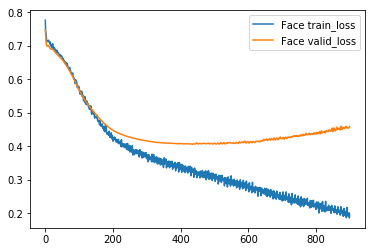

In [17]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='Face train_loss')
mplot.plot(valid_loss, label='Face valid_loss')
mplot.legend()
mplot.show()

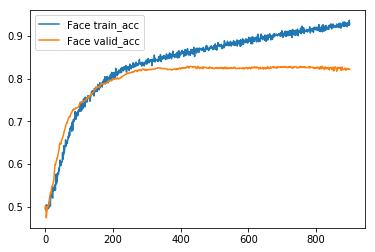

In [18]:
# import matplotlib.pyplot as mplot
mplot.plot(train_acc, label='Face train_acc')
mplot.plot(valid_acc, label='Face valid_acc')
mplot.legend()
mplot.show()

In [19]:
test_acc, test_loss = [], []

with tf.Session() as sess:
    # Restore the validated model
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints/'))
    
    ################## Test
    acc_batch = []
    loss_batch = []    
    # Loop over batches
    for x, y in get_batches(batch_size=100, X=X_test_norm, y=Y_test_onehot):

        # Feed dictionary
        feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0}

        # Loss
        loss, acc = sess.run([cost, accuracy], feed_dict = feed)
        acc_batch.append(acc)
        loss_batch.append(loss)

    # Store
    test_acc.append(np.mean(acc_batch))
    test_loss.append(np.mean(loss_batch))

    # Print info for every iter/epoch
    print("Test loss: {:6f}".format(np.mean(test_loss)),
          "Test acc: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints/dcnn-face-yalda-Copy5.ckpt
Test loss: 0.357055 Test acc: 0.858214
